We'll go through an analyze an XDF using some util functions provided.

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import eeg_utils as ez
from scipy import signal
from preprocessing import *
from plotting import *
from classify import *
from import_data import *
data_dir = './DataCollection/outputs/Ollie_SSVEP/'

In [37]:
files = get_files(data_dir)
files

['./DataCollection/outputs/Ollie_SSVEP/joelle_data_trial_000.txt',
 './DataCollection/outputs/Ollie_SSVEP/joelle_good_10.8Hz_000.xdf',
 './DataCollection/outputs/Ollie_SSVEP/joelle_good_10Hz_000.xdf',
 './DataCollection/outputs/Ollie_SSVEP/joelle_good_11.6Hz_000.xdf',
 './DataCollection/outputs/Ollie_SSVEP/joelle_good_12.4Hz_000.xdf',
 './DataCollection/outputs/Ollie_SSVEP/joelle_good_13.2Hz_000.xdf',
 './DataCollection/outputs/Ollie_SSVEP/joelle_good_14.8Hz_000.xdf',
 './DataCollection/outputs/Ollie_SSVEP/joelle_good_14Hz_000.xdf',
 './DataCollection/outputs/Ollie_SSVEP/joelle_good_15.6Hz_000.xdf',
 './DataCollection/outputs/Ollie_SSVEP/joelle_good_8.4Hz_000.xdf',
 './DataCollection/outputs/Ollie_SSVEP/joelle_good_8.4Hz_001.xdf',
 './DataCollection/outputs/Ollie_SSVEP/joelle_good_9.2Hz_000.xdf',
 './DataCollection/outputs/Ollie_SSVEP/joelle_meta_trial_000.txt']

In [88]:
fname = files[2]
raw_eeg = ez.loadxdf(fname)
fs = raw_eeg['fs']
# Let's print out raw_eeg's keys (it's a dict)
print(raw_eeg.keys())

dict_keys(['eeg_data', 'eeg_time', 'event_data', 'event_time', 'channels', 'fs', 'fs_i'])


Our raw data is stored in `raw_eeg['eeg_data']` so let's check out that shape

In [89]:
print(f"Shape of our data is: {raw_eeg['eeg_data'].shape}")

Shape of our data is: (20540, 8)


We can epoch to particular events (such as `'0'`) using the function `epoch` within `eeg_utils`:

In [90]:
print(f"Here are the events we have in our data: {raw_eeg['event_data']}")

Here are the events we have in our data: [['10'], ['11'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0']]


In [91]:
times = raw_eeg['event_time']

In [92]:
times

array([2234.2485041 , 2236.24769609, 2240.24761086, 2243.24851355,
       2244.24204384, 2247.24185032, 2248.10264452, 2251.101971  ,
       2251.97682899, 2254.97685688, 2255.82396137, 2258.82414655,
       2259.60169825, 2262.60189183, 2263.44924823, 2266.45022791,
       2267.28261551, 2270.28237539, 2271.15109378, 2274.15041426,
       2274.92105516, 2277.92113104, 2278.85169464, 2281.85186022,
       2282.72099251, 2285.7198196 , 2286.56721689, 2289.56791787,
       2290.55355677, 2293.55305815, 2294.49748775, 2297.49806243])

In [93]:
fs = raw_eeg['fs']
fs

250

In [94]:
epoch_s = -100 # 100 ms before stimulus onset
epoch_e = 5000  # 600 ms after stimulus onset

erp_0 = ez.epoch(raw_eeg, epoch_s, epoch_e, '0')

Let's examine the structure of `erp_0` which is also a dict, but has a different structure than `raw_eeg`:

In [95]:
print(erp_0.keys())

dict_keys(['bin_data', 'bin_times', 'events', 'fs', 'channels'])


Our EEG data is stored in `erp_0['bin_data']` and has shape $\mathrm{epochs} \times \mathrm{samples} \times \mathrm{channels}$

In [96]:
print(erp_0['bin_data'].shape)

(16, 1275, 8)


So we have:
- 16 epochs
- 1275 samples per epoch
- 8 channels per sample

Let's the first epoch, all samples, first channel

In [97]:
def make_df(data, col_names, idx=0):
    df = pd.DataFrame()
    for i,cn in enumerate(col_names):
        df[cn] = data[idx,:,i]
    return df

In [98]:
col_names = ['Fp1','O1', 'O2','C3','C4','P3','P4','Pz']

In [99]:
eeg = make_df(erp_0['bin_data'], col_names)
filt_eeg = filter_eeg(eeg, Fs=fs, low=8, high=20, notch_freq=60.0)

In [100]:
filt_eeg

,Fp1,O1,O2,C3,C4,P3,P4,Pz
0,0.158364,-0.002283,0.005040,-0.052719,-0.069094,-0.046850,-0.077607,-0.055527
1,0.748842,0.560999,-0.646455,0.885825,-0.119145,0.023653,-0.174952,0.211801
2,1.110893,0.990853,-1.265330,1.750695,-0.226935,0.083018,-0.289755,0.431384
3,1.067122,1.182603,-1.816349,2.470254,-0.433639,0.122511,-0.432950,0.564636
4,0.531875,1.082877,-2.260890,2.978516,-0.751020,0.137677,-0.604068,0.589360
...,...,...,...,...,...,...,...,...
1270,3.437345,0.650805,6.178031,-2.521346,1.687022,-4.626936,2.692485,0.293544
1271,3.244992,0.623130,5.759618,-2.361413,1.639032,-4.208617,2.653203,0.255003
1272,2.550507,0.490262,4.445695,-1.829012,1.284101,-3.200980,2.097879,0.176154
1273,1.462661,0.268911,2.421419,-1.016054,0.677986,-1.744879,1.126115,0.067990


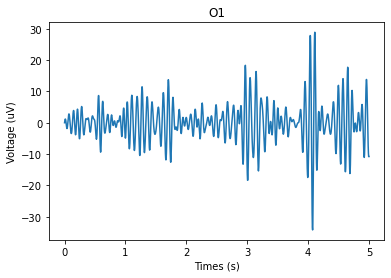

In [101]:
plot_channel(filt_eeg, 'O1', fs, start=0, end=5)

In [102]:
power = power_spectrum(filt_eeg, fs)

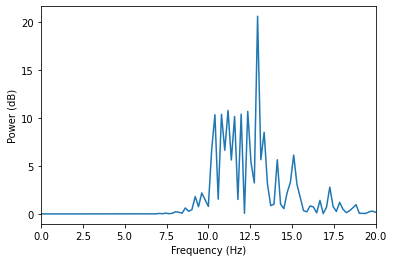

In [103]:
plot_power(power,'O2',20)

(0.0, 20.0)

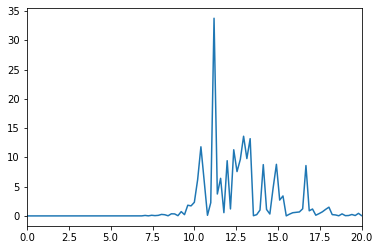

In [104]:
O1 = list(filt_eeg['O1'])
f,p = signal.periodogram(O1, fs)
plt.plot(f,p)
plt.xlim(0,20)
#plt.ylim(0,100)

In [112]:
count = 0 
for idx in range(16):
    eeg = make_df(erp_0['bin_data'], col_names, idx)
    filt_eeg = filter_eeg(eeg, Fs=fs, low=6, high=20, notch_freq=60.0)
    O1 = list(filt_eeg['O1'])
    f,p = signal.periodogram(O1, fs)
    df = f[1]-f[0]
    freqs = np.arange(8.4,16,0.8)
    fv = calc_featvec(p, df, freqs, band_width=0.4, num_harmonics=1)
    pred = pick_freq(fv, freqs)
    if pred == 10.000000000000002:
        count += 1
    print(pred)
print('------------------')
print("accuracy: " + str(count/16))


11.600000000000003
10.000000000000002
10.000000000000002
11.600000000000003
10.000000000000002
10.000000000000002
10.000000000000002
10.000000000000002
10.000000000000002
10.000000000000002
12.400000000000004
10.800000000000002
10.800000000000002
10.000000000000002
10.000000000000002
10.800000000000002
------------------
accuracy: 0.625
